**Problem statement:**  

consider the classic german tank estimation problem.  Suppose you see n (perhaps n = 15) marathon runners and the largest number on the jersey is 105, then we estimate that the largest jersey number of all marathon runners is (15+1)/15 * 105 -1 = 111 -- i.e. that there are 111 marathon runners with numberings 1, 2, 3, ..., 110, 111.  

This problem asks us to run simulations and compare actual maximal numbers with those of our estimates, for various sample sizes (where we sample without replacement).  Then it asks us to plot the problem -- which turns out to be a bell curve. 

note: this one is a bit different than typical problem statements

Below is the basic Numba implementation that I did for this

In [1]:
import numpy as np
import numba
import time
np.set_printoptions(precision = 2, linewidth=180)
# huge find:%%!
# press 'l' in command mode (esc) to toggle line numbers in a given cell, which is quite helpful for auditing
import matplotlib.pyplot as plt



@numba.jit(nopython= True)
def run_sim(percentage_to_sample, r_trials):
    # A = number of senators against of the bill, odd naming convention but from the book
    # M = total who miss the vote -- we in effect are conditioning on this...
    # need to be greater than this threshold
    percentage_error_estimates = np.zeros(r_trials)
    for idx in range(r_trials):
        bigN = int(np.random.uniform(100, 1000 + 1))
        number_to_sample = int(percentage_to_sample * bigN)
        positions = np.random.choice(bigN, number_to_sample, False) + 1
        # the + 1 that is broadcast in is to deal with python indexing at zero, but the problem indexes at one
        maximal_number = np.max(positions)
        estimate_via_formula = (number_to_sample + 1) / number_to_sample * maximal_number - 1
        percent_error = estimate_via_formula / bigN
        percentage_error_estimates[idx] += percent_error
    return percentage_error_estimates


time taken:  1.44056 

the mean is 0.999986640036  and variance is  0.00352396532286


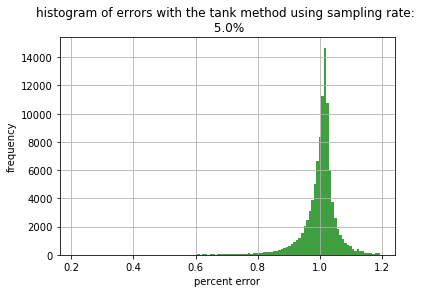

In [2]:
my_sampling_rate = 0.05
title = "histogram of errors with the tank method using sampling rate: \n " + str(my_sampling_rate*100) + "%"
beg_time = time.clock()
my_array = run_sim(my_sampling_rate, r_trials = 100000)

the_mean = np.mean(my_array)
print("time taken: ", time.clock()- beg_time, "\n")
the_variance = np.mean((my_array - the_mean)**2)
print("the mean is", the_mean, " and variance is ", the_variance)
# n, bins, patches = plt.hist(my_array, bins= 120, normed=True, facecolor='green', alpha=0.75)
n, bins, patches = plt.hist(my_array, bins= 120,normed= False , facecolor='green', alpha=0.75)
# I haven't decided how I feel about it being normed or not... exlanation in the docs didn't do much for me, though it did say normed by default is False
# note: alpha is just the amount of transparency

plt.xlabel('percent error')
plt.ylabel('frequency')
plt.title(title)
# plt.axis([40, 160, 0, 0.03])
plt.grid(True)

plt.show()


Below is the cython implemented simulation (I only returned the relevant array -- did not do the graphing here)

In [3]:
# %load_ext cythonmagic

In [4]:
%load_ext Cython
# from libc.stdlib cimport rand, RAND_MAX
# from libc.stdlib import rand, RAND_MAX


In [5]:
# from libc.stdlib import rand, RAND_MAX


In [6]:
%%cython
import numpy as np
cimport numpy as np
# import numba
# np.import_array()
# cimport cython

from libc.stdlib cimport rand, RAND_MAX
# https://stackoverflow.com/questions/38768637/cython-in-jupyter-notebook
# key comments in there is "
# "you use cython code in special magic cells. You define a cython cell by starting your cell with %%cython"

def cy_run_sim(float percentage_to_sample, int r_trials):
    """
    This is a very suboptimal implementation because it requires sampling without replacement  of arrays that 
    have a variable (and indeed random) size.  Importing a proper sophisticated random number library from C++ or 
    perhaps regular C (that I didn't find) would fix this.  
    
    Instead I used rand and RAND_MAX which are not even close to being the right tools for this job.  
    Notice that while verbose, in problem 11, because the arrays had a constant size, we could implement knuth et al 
    algorithm and use rand and RAND_MAX to effectively sample without replacement.  (Though even then that violate 
    my common sense rule of don't start from scratch when basic highly optimized and bug free modules exist for what
    you're trying to do.)  
     """
    cdef int i
    cdef int j
    cdef int biggestval
    cdef int curval
    cdef int curidx
    # the below link is what reminded me I need to declare the typing of the i because I'm using it...
    # https://lectures.quantecon.org/py/need_for_speed.html#cython

    # senators_array[0:total_in_favor] += 1
    cdef int upperval = 1000 # inclusive
    cdef int lowerval = 100 # inclusive

    cdef my_interval = upperval - lowerval + 1
    # almost like an affine translation though thats a bit of an abuse of language

    cdef int my_idx = lowerval
    cdef int bigN = 1000
    # np.random.shuffle(senators_array) # its this line and this line alone that seems to be killing performance...
    cdef int number_to_sample = 0

    # I need to vectorize this if I want to minimize calls to numpy routines...
    cdef np.ndarray[np.int_t, ndim = 1, negative_indices = False, mode = 'c']ones = np.ones(r_trials, dtype= np.int64) # one for each trial
    cdef np.ndarray[np.int_t, ndim = 1, negative_indices = False, mode = 'c']sequence = np.arange(1, upperval +1, dtype= np.int64) # one for each trial
    cdef np.ndarray[np.int_t, ndim = 2, negative_indices = False, mode = 'c']main_matrix = np.outer(ones, sequence)
    # not sure if I need a declaration here

    cdef np.ndarray[np.double_t, ndim = 1, negative_indices = False, mode = 'c'] scoring_array = np.zeros(r_trials, dtype = np.float64)

    for i in range(r_trials):
        # running_count += senators_array[i]
        # running_count += senators_array[magical_indices[i]]
        # my_idx = np.random.randint(r - i) # but even if I moved this out to a c
        bigN = lowerval
        bigN += int((my_interval) * (float(rand())/RAND_MAX)) # this should be an integer I think
        # the real problem so far as I can tell is there isn't a good way to sample without replacement in C
        # so I'm stuck using this monstrosity that I hacked together
        number_to_sample = int((percentage_to_sample * float(bigN))) # maybe an issue here, not sure
        # now how can I somewhat efficiently sample from this without replacement????
        biggestval = 0

        for j in range(number_to_sample):
            curidx = int((bigN - j) * (float(rand())/RAND_MAX))
            curval = main_matrix[i, curidx]
            if curval > biggestval:
                biggestval = curval
            main_matrix[i, curidx], main_matrix[i, bigN - j - 1] = main_matrix[i, bigN - j - 1], main_matrix[i, curidx]
            # the swap

        scoring_array[i] += (((float(number_to_sample) + 1.0) / float(number_to_sample)) * float(biggestval) - 1.0)/ float(bigN)                

    return scoring_array

# answer = run_sim(0.05, 100)
# answer = run_sim(A= 49, M=3, n_trials=1000000)
# print(answer)


In [7]:
result = cy_run_sim(0.2, 100000)
np.mean(result)

1.0000239109243396

In [8]:
the_sampling_rate = 0.2
total_trials = 500000 
# anything much higher than this runs into memory issues in the cython implementation, which is unfortunate

my_numba_generated_array = run_sim(the_sampling_rate, r_trials = total_trials)
my_cython_generated_array = cy_run_sim(the_sampling_rate, total_trials)

the_mean_numba = np.mean(my_numba_generated_array)
the_mean_cython = np.mean(my_cython_generated_array)

the_variance_numba = np.mean((my_numba_generated_array - the_mean_numba)**2)
the_variance_cython = np.mean((my_cython_generated_array - the_mean_cython)**2)


print("means")
print(the_mean_numba, the_mean_cython, "\n")
print("variance")
print(the_variance_numba, the_variance_cython, "\n")


means
1.00002398999 0.999994583424 

variance
0.000195713249296 0.00019511687144 



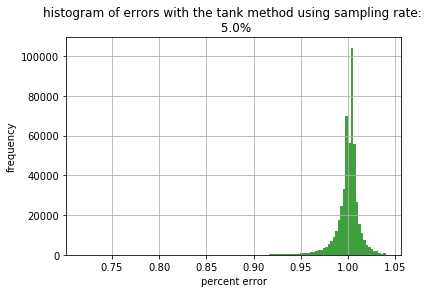

In [9]:
n, bins, patches = plt.hist(my_numba_generated_array, bins= 120,normed= False , facecolor='green', alpha=0.75)
# I haven't decided how I feel about it being normed or not... exlanation in the docs didn't do much for me, though it did say normed by default is False
# note: alpha is just the amount of transparency

plt.xlabel('percent error')
plt.ylabel('frequency')
plt.title(title)
# plt.axis([40, 160, 0, 0.03])
plt.grid(True)

plt.show()


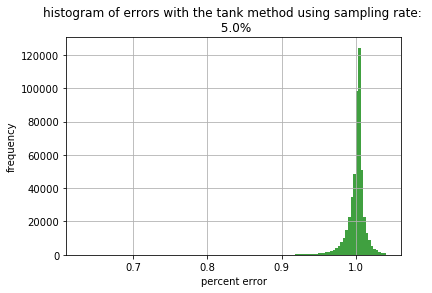

In [10]:
n, bins, patches = plt.hist(my_cython_generated_array, bins= 120,normed= False , facecolor='green', alpha=0.75)
# I haven't decided how I feel about it being normed or not... exlanation in the docs didn't do much for me, though it did say normed by default is False
# note: alpha is just the amount of transparency

plt.xlabel('percent error')
plt.ylabel('frequency')
plt.title(title)
# plt.axis([40, 160, 0, 0.03])
plt.grid(True)

plt.show()


In [11]:
%timeit my_numba_generated_array = run_sim(the_sampling_rate, r_trials = total_trials)

1 loop, best of 3: 1.62 s per loop


In [12]:
%timeit my_cython_generated_array = cy_run_sim(the_sampling_rate, total_trials)

1 loop, best of 3: 5.96 s per loop
